In [58]:
import torch
import torchvision
import torchvision.transforms as transforms

In [59]:
transform = transforms.ToTensor()

# train data 가져오기
# 기본 과제 MNIST -> 심화 과제 CIFAR10으로 변경
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

In [60]:
# test data 가져오기
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [61]:
# batch size = 64로 동일하게
# 기본 과제는 64 -> 심화 과제는 256
batch_size = 256

# trainset, testset에 대한 dataloader
# trainset은 shuffle=True, testset은 shuffle=False
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [62]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [63]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [64]:
trainloader

In [65]:
testloader

In [66]:
# CIFAR10의 shape 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# MNIST : torch.Size([64, 1, 28, 28]) torch.Size([64])
# CIFAR 10 : torch.Size([256, 3, 32, 32]) torch.Size([256]) => 컬러 이미지라서 3(RGB), width와 heigt이 32

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [67]:
from torch import nn

# 모델 정의
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    # CIFAR-10도 10개의 클래스를 분류됨.

    # 활성화 함수 : ReLU -> LeaklyReLU
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [68]:
# SGD 모델, ADAM 모델
input_dim = 3 * 32 * 32
model_sgd = Model(input_dim, 1024)
model_adam = Model(input_dim, 1024)

In [73]:
from torch.optim import Adam
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

lr = 0.001

n_epochs = 50
batch_size = 256

# optimizer : Adam vs SGD
optimizer_adam = Adam(model_adam.parameters(), lr=lr)
optimizer_sgd = SGD(model_sgd.parameters(), lr=lr)

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(acc1, acc2, label1='Model 1', label2='Model 2'):
  x = np.arange(len(acc1))

  plt.plot(x, acc1, label=label1, marker='.')
  plt.plot(x, acc2, label=label2, marker='v')
  plt.legend()
  plt.show()

def train_model(model, trainloader, optimizer):
  model = model.to('cuda')
  loss_fn = nn.CrossEntropyLoss()
  train_accs = []

  for epoch in range(n_epochs):
    total_loss = 0
    model.train()

    for data in trainloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      optimizer.zero_grad()
      preds = model(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    model.eval()
    acc = accuracy(model, trainloader)
    train_accs.append(acc)
    print(f'[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Acc: {train_accs[-1]:.4f}')

  return train_accs

In [70]:
# Adam으로 학습 진행

train_accs_adam = train_model(model_adam, trainloader, optimizer_adam)

[Epoch 1] Loss: 426.9277 | Train Acc: 0.2107
[Epoch 2] Loss: 385.5020 | Train Acc: 0.3031
[Epoch 3] Loss: 363.3959 | Train Acc: 0.3335
[Epoch 4] Loss: 347.2396 | Train Acc: 0.3792
[Epoch 5] Loss: 335.2868 | Train Acc: 0.3929
[Epoch 6] Loss: 326.2116 | Train Acc: 0.4029
[Epoch 7] Loss: 317.2719 | Train Acc: 0.4340
[Epoch 8] Loss: 311.2260 | Train Acc: 0.4351
[Epoch 9] Loss: 303.6506 | Train Acc: 0.4408
[Epoch 10] Loss: 299.2432 | Train Acc: 0.4705
[Epoch 11] Loss: 291.7617 | Train Acc: 0.4784
[Epoch 12] Loss: 286.8495 | Train Acc: 0.4884
[Epoch 13] Loss: 281.1222 | Train Acc: 0.5038
[Epoch 14] Loss: 279.0318 | Train Acc: 0.5074
[Epoch 15] Loss: 274.5377 | Train Acc: 0.4793
[Epoch 16] Loss: 269.5038 | Train Acc: 0.5222
[Epoch 17] Loss: 268.8552 | Train Acc: 0.5231
[Epoch 18] Loss: 262.6324 | Train Acc: 0.5415
[Epoch 19] Loss: 259.7973 | Train Acc: 0.5333
[Epoch 20] Loss: 255.8916 | Train Acc: 0.5359
[Epoch 21] Loss: 252.5517 | Train Acc: 0.5457
[Epoch 22] Loss: 250.8482 | Train Acc: 0.55

In [71]:
# SGD로 학습 진행

train_accs_sgd = train_model(model_sgd, trainloader, optimizer_sgd)

[Epoch 1] Loss: 450.7095 | Train Acc: 0.1401
[Epoch 2] Loss: 448.9990 | Train Acc: 0.1374
[Epoch 3] Loss: 447.4979 | Train Acc: 0.1499
[Epoch 4] Loss: 446.0359 | Train Acc: 0.1738
[Epoch 5] Loss: 444.5572 | Train Acc: 0.1943
[Epoch 6] Loss: 442.9537 | Train Acc: 0.2102
[Epoch 7] Loss: 441.2305 | Train Acc: 0.2203
[Epoch 8] Loss: 439.4480 | Train Acc: 0.2284
[Epoch 9] Loss: 437.4167 | Train Acc: 0.2325
[Epoch 10] Loss: 435.1512 | Train Acc: 0.2381
[Epoch 11] Loss: 432.8311 | Train Acc: 0.2440
[Epoch 12] Loss: 430.4417 | Train Acc: 0.2444
[Epoch 13] Loss: 427.9251 | Train Acc: 0.2459
[Epoch 14] Loss: 425.3316 | Train Acc: 0.2535
[Epoch 15] Loss: 422.7284 | Train Acc: 0.2585
[Epoch 16] Loss: 420.0841 | Train Acc: 0.2594
[Epoch 17] Loss: 417.4638 | Train Acc: 0.2656
[Epoch 18] Loss: 414.8322 | Train Acc: 0.2669
[Epoch 19] Loss: 412.3130 | Train Acc: 0.2711
[Epoch 20] Loss: 409.8674 | Train Acc: 0.2749
[Epoch 21] Loss: 407.5210 | Train Acc: 0.2810
[Epoch 22] Loss: 405.2079 | Train Acc: 0.28

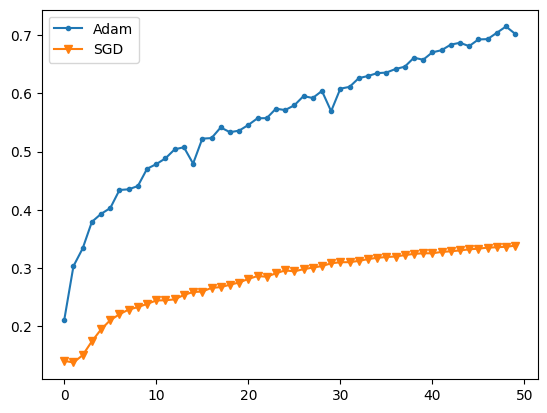

In [74]:
plot_acc(train_accs_adam, train_accs_sgd, label1='Adam', label2='SGD')

In [86]:
# 모델 정의 - Activation 함수가 Sigmoid
class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    # CIFAR-10도 10개의 클래스를 분류됨.

    # 활성화 함수 : Sigmoid
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

# 모델 정의 - Activation 함수가 Leaky ReLU
class Model1(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    # CIFAR-10도 10개의 클래스를 분류됨.

    # 활성화 함수 : ReLU -> LeaklyReLU
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [87]:
# Sigmoid 모델, LeakyReLU 모델
input_dim = 3 * 32 * 32

model_sigmoid = Model2(input_dim, 1024)
model_leakyrelu = Model1(input_dim, 1024)

optimizer_sigmoid = Adam(model_sigmoid.parameters(), lr=lr)
optimizer_leakyrelu = Adam(model_leakyrelu.parameters(), lr=lr)

In [88]:
train_accs_sigmoid = train_model(model_sigmoid, trainloader, optimizer_sigmoid)

[Epoch 1] Loss: 410.9990 | Train Acc: 0.3195
[Epoch 2] Loss: 393.4752 | Train Acc: 0.3491
[Epoch 3] Loss: 387.6949 | Train Acc: 0.3758
[Epoch 4] Loss: 383.5748 | Train Acc: 0.3795
[Epoch 5] Loss: 380.5614 | Train Acc: 0.4070
[Epoch 6] Loss: 378.8979 | Train Acc: 0.4097
[Epoch 7] Loss: 376.9818 | Train Acc: 0.4178
[Epoch 8] Loss: 375.8678 | Train Acc: 0.4179
[Epoch 9] Loss: 374.3158 | Train Acc: 0.4287
[Epoch 10] Loss: 373.1052 | Train Acc: 0.4302
[Epoch 11] Loss: 371.7510 | Train Acc: 0.4447
[Epoch 12] Loss: 370.9330 | Train Acc: 0.4384
[Epoch 13] Loss: 369.7159 | Train Acc: 0.4484
[Epoch 14] Loss: 369.2886 | Train Acc: 0.4577
[Epoch 15] Loss: 368.0340 | Train Acc: 0.4618
[Epoch 16] Loss: 367.3994 | Train Acc: 0.4622
[Epoch 17] Loss: 365.9952 | Train Acc: 0.4703
[Epoch 18] Loss: 364.8617 | Train Acc: 0.4848
[Epoch 19] Loss: 364.7169 | Train Acc: 0.4676
[Epoch 20] Loss: 364.2104 | Train Acc: 0.4679
[Epoch 21] Loss: 363.4931 | Train Acc: 0.4590
[Epoch 22] Loss: 363.1808 | Train Acc: 0.49

In [89]:
train_accs_leaklyrelu = train_model(model_leakyrelu, trainloader, optimizer_leakyrelu)

[Epoch 1] Loss: 432.5449 | Train Acc: 0.1979
[Epoch 2] Loss: 394.8990 | Train Acc: 0.2659
[Epoch 3] Loss: 370.3257 | Train Acc: 0.3273
[Epoch 4] Loss: 354.7247 | Train Acc: 0.3477
[Epoch 5] Loss: 340.0695 | Train Acc: 0.3775
[Epoch 6] Loss: 330.7199 | Train Acc: 0.3968
[Epoch 7] Loss: 321.9982 | Train Acc: 0.4079
[Epoch 8] Loss: 315.4271 | Train Acc: 0.4199
[Epoch 9] Loss: 308.3430 | Train Acc: 0.4429
[Epoch 10] Loss: 301.7310 | Train Acc: 0.4599
[Epoch 11] Loss: 296.8274 | Train Acc: 0.4703
[Epoch 12] Loss: 291.4281 | Train Acc: 0.4779
[Epoch 13] Loss: 285.8888 | Train Acc: 0.4787
[Epoch 14] Loss: 281.1401 | Train Acc: 0.5018
[Epoch 15] Loss: 278.2149 | Train Acc: 0.4933
[Epoch 16] Loss: 274.4579 | Train Acc: 0.5128
[Epoch 17] Loss: 270.0260 | Train Acc: 0.5123
[Epoch 18] Loss: 267.5562 | Train Acc: 0.5183
[Epoch 19] Loss: 263.2980 | Train Acc: 0.5290
[Epoch 20] Loss: 260.7577 | Train Acc: 0.5378
[Epoch 21] Loss: 256.4563 | Train Acc: 0.5405
[Epoch 22] Loss: 252.6612 | Train Acc: 0.54

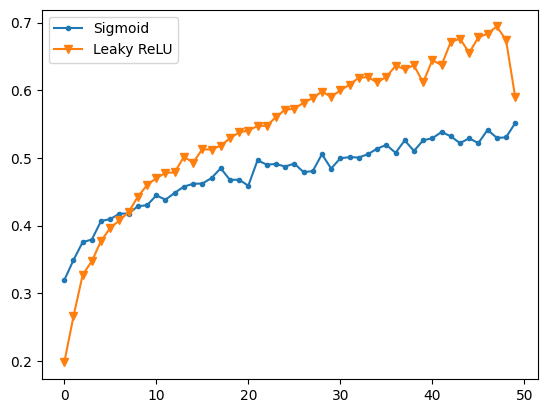

In [90]:
plot_acc(train_accs_sigmoid, train_accs_leaklyrelu, label1='Sigmoid', label2='Leaky ReLU')

In [92]:
# 모델 정의 - Activation 함수가 Leaky ReLU with dropout
class Model3(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.drop1 = nn.Dropout(0.1)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.drop2 = nn.Dropout(0.1)
    self.layer3 = nn.Linear(n_dim, 10)
    self.drop3 = nn.Dropout(0.1)
    # CIFAR-10도 10개의 클래스를 분류됨.

    # 활성화 함수 : LeaklyReLU
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.drop1(self.act(self.layer1(x)))
    x = self.drop2(self.act(self.layer2(x)))
    x = self.drop3(self.layer3(x))

    return x

In [93]:
input_dim = 3 * 32 * 32
model_dropout = Model3(input_dim, 1024)

optimizer_dropout = Adam(model_dropout.parameters(), lr=lr)

In [111]:
lr = 0.001

n_epochs = 50
batch_size = 256

train_accs = []
test_accs = []

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

def train_model_with_test(model, trainloader, testloader, optimizer):
  model = model.to('cuda')
  loss_fn = nn.CrossEntropyLoss()
  train_accs = []
  test_accs = []

  for epoch in range(n_epochs):
    total_loss = 0

    model.train()
    for data in trainloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      optimizer.zero_grad()
      preds = model(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f'[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Acc: {train_accs[-1]:.4f} | Test Acc: {test_acc:.4f}')
  plot_acc(train_accs, test_accs)
  return train_accs, test_accs

[Epoch 1] Loss: 130.4066 | Train Acc: 0.7648 | Test Acc: 0.4873
[Epoch 2] Loss: 129.7199 | Train Acc: 0.7642 | Test Acc: 0.4844
[Epoch 3] Loss: 127.7883 | Train Acc: 0.7684 | Test Acc: 0.4806
[Epoch 4] Loss: 124.9981 | Train Acc: 0.7702 | Test Acc: 0.4884
[Epoch 5] Loss: 127.1409 | Train Acc: 0.7742 | Test Acc: 0.4893
[Epoch 6] Loss: 126.6202 | Train Acc: 0.7774 | Test Acc: 0.4900
[Epoch 7] Loss: 124.9726 | Train Acc: 0.7776 | Test Acc: 0.4887
[Epoch 8] Loss: 124.2396 | Train Acc: 0.7759 | Test Acc: 0.4884
[Epoch 9] Loss: 124.9187 | Train Acc: 0.7846 | Test Acc: 0.4934
[Epoch 10] Loss: 123.2939 | Train Acc: 0.7819 | Test Acc: 0.4916
[Epoch 11] Loss: 122.6393 | Train Acc: 0.7734 | Test Acc: 0.4884
[Epoch 12] Loss: 122.5261 | Train Acc: 0.7824 | Test Acc: 0.4913
[Epoch 13] Loss: 121.2571 | Train Acc: 0.7888 | Test Acc: 0.4922
[Epoch 14] Loss: 119.9569 | Train Acc: 0.7753 | Test Acc: 0.4913
[Epoch 15] Loss: 123.4988 | Train Acc: 0.7902 | Test Acc: 0.4834
[Epoch 16] Loss: 121.3791 | Train 

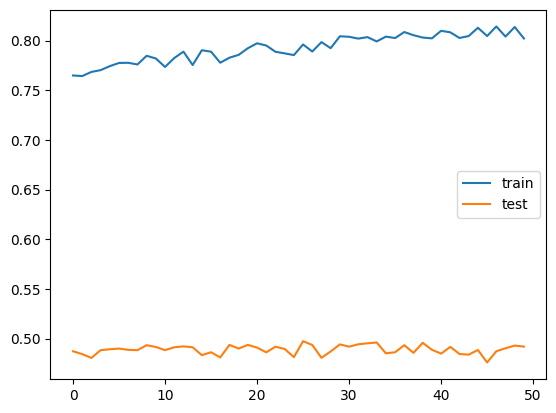

In [112]:
# 학습
train_accs_dropout, test_accs_dropout = train_model_with_test(model_dropout, trainloader, testloader, optimizer_dropout)